In [158]:
import pickle
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', -1)
np.random.seed(10)

with open(f"data/label/train_labelled.pkl", 'rb') as fid:
    train = pickle.load(fid)
with open(f"data/label/dev_labelled.pkl", 'rb') as fid:
    dev = pickle.load(fid)
with open(f"data/label/test_labelled.pkl", 'rb') as fid:
    test = pickle.load(fid)

In [153]:
dev.shape

(4982, 25)

# Data Label Distributions 

Majority vote distributions across all sentence, term pair instance for the different classes. For all three:

- non-labelled data is about 15-20%
- hypernyms and hyponyms are relatively equal at about .6-.8%
- negatives are about 80%

In [155]:
train \
    .groupby('majority_vote') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,majority_vote,count,prop
0,-1,50378,0.189593
1,0,211475,0.795866
2,1,1807,0.006800
3,2,2057,0.007741


In [156]:
dev \
    .groupby('majority_vote') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,majority_vote,count,prop
0,-1,814,0.163388
1,0,4070,0.816941
2,1,53,0.010638
3,2,45,0.009033


In [157]:
test \
    .groupby('majority_vote') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,majority_vote,count,prop
0,-1,553,0.245451
1,0,1649,0.731913
2,1,26,0.011540
3,2,25,0.011096


# Exclude Points without labels 

We can't use labels where we don't have any coverage by our labeling functions. Here we see that now the distribution of term pairs is overwhelmingly negative with only about 8-10% positive term pairs.

In [130]:
# filter out data points without any labels
train = train[train.majority_vote >= 0]
dev = dev[dev.majority_vote >= 0]
test = test[test.majority_vote >= 0]

In [109]:
train \
    .groupby('majority_vote') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,majority_vote,count,prop
0,0,211475,0.982056
1,1,1807,0.008391
2,2,2057,0.009552


In [110]:
dev \
    .groupby('majority_vote') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,majority_vote,count,prop
0,0,4070,0.976488
1,1,53,0.012716
2,2,45,0.010797


In [111]:
test \
    .groupby('majority_vote') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,majority_vote,count,prop
0,0,1649,0.970000
1,1,26,0.015294
2,2,25,0.014706


# Unique Term Pair Distributions

The above distributions over count term pairs that show up more frequently. Here we first look at unique term pair label distributions. We see that the number of unique term pairs is about 40% less than overall term pairs and the relative proportions are still quite similar.

In [112]:
train \
    .groupby('majority_vote') \
    .term_pair \
    .agg(nunique='nunique') \
    .reset_index() \
    .assign(prop=lambda df: df['nunique'] / df['nunique'].sum())

,majority_vote,nunique,prop
0,0,114142,0.980121
1,1,1148,0.009858
2,2,1167,0.010021


In [113]:
dev \
    .groupby('majority_vote') \
    .term_pair \
    .agg(nunique='nunique') \
    .reset_index() \
    .assign(prop=lambda df: df['nunique'] / df['nunique'].sum())

,majority_vote,nunique,prop
0,0,3093,0.974480
1,1,43,0.013548
2,2,38,0.011972


In [114]:
test \
    .groupby('majority_vote') \
    .term_pair \
    .agg(nunique='nunique') \
    .reset_index() \
    .assign(prop=lambda df: df['nunique'] / df['nunique'].sum())

,majority_vote,nunique,prop
0,0,1337,0.971657
1,1,19,0.013808
2,2,20,0.014535


We can look at distributions of term pair counts to get a sense of this. Most terms have 1 or two occurrences. There are more outliers for no-relation however. Some of these with more occurrences may be problematic and want to be screened (i.e. group and species).

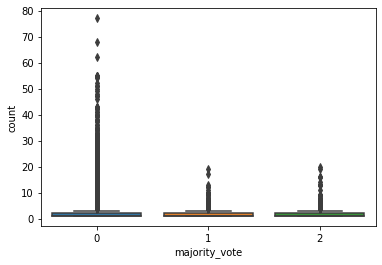

In [79]:
tp_train = \
    train \
    .groupby(['majority_vote', 'term_pair']) \
    .term_pair \
    .agg(count='count') \
    .reset_index()
sns.boxplot(data = tp_train, x = 'majority_vote', y = 'count')

In [80]:
tp_train[tp_train.majority_vote > 0].sort_values('count', ascending=False).head(10)

,majority_vote,term_pair,count
131314,2,"(group, specie)",20
131594,2,"(permeability, membrane)",19
130663,1,"(specie, group)",19
130645,1,"(signal transduction, signal)",17
131263,2,"(gene, allele)",16
130883,2,"(artery, arteriole)",16
131784,2,"(signal, response)",16
131160,2,"(energy, entropy)",14
131737,2,"(rna, mRNA)",13
131782,2,"(signal, release)",13


In [103]:
import re
re.sub('<.+?>', '', '<em data-effect="italics">α</em>-helix')

'α-helix'

# Sentence Distributions

The other piece of our input data is sentences. Our data has many term pairs for each sentence so first we can look at how many sentences are in each split.

In [81]:
len(train.groupby('text'))

30711

In [82]:
len(dev.groupby('text'))

2193

In [83]:
len(test.groupby('text'))

835

Next we can see how many of these sentences have a positive label in them. At the sentence level closer to 10% of sentences have a taxonomic relation in them.

In [84]:
train \
    .groupby('text') \
    .majority_vote \
    .agg(hyponym=lambda x: any(x == 1), hypernym=lambda x: any(x == 2)) \
    .reset_index() \
    .groupby(['hyponym', 'hypernym']) \
    .text \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hyponym,hypernym,count,prop
0,False,False,27669,0.900948
1,False,True,1468,0.047800
2,True,False,1397,0.045489
3,True,True,177,0.005763


In [85]:
dev \
    .groupby('text') \
    .majority_vote \
    .agg(hyponym=lambda x: any(x == 1), hypernym=lambda x: any(x == 2)) \
    .reset_index() \
    .groupby(['hyponym', 'hypernym']) \
    .text \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hyponym,hypernym,count,prop
0,False,False,1923,0.876881
1,False,True,111,0.050616
2,True,False,140,0.063839
3,True,True,19,0.008664


In [86]:
test \
    .groupby('text') \
    .majority_vote \
    .agg(hyponym=lambda x: any(x == 1), hypernym=lambda x: any(x == 2)) \
    .reset_index() \
    .groupby(['hyponym', 'hypernym']) \
    .text \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hyponym,hypernym,count,prop
0,False,False,769,0.920958
1,False,True,29,0.034731
2,True,False,34,0.040719
3,True,True,3,0.003593


Finally we can look at the distribution of total term pair counts within individual sentences.

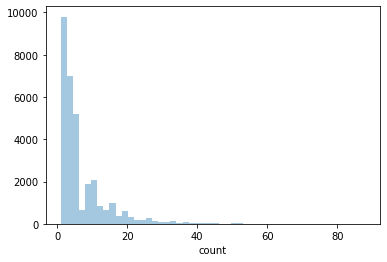

In [115]:
tmp = \
    train \
    .groupby('text') \
    .term_pair \
    .agg(count='count') \
    .reset_index() \
    .sort_values('count', ascending=False)
sns.distplot(tmp['count'], norm_hist=False, kde=False)

In [116]:
tmp.sort_values('count', ascending=False).head(30)

,text,count
28365,"This phylum is further classified into five subphyla: Trilobita (trilobites, all extinct), Chelicerata (horseshoe crabs, spiders, scorpions, ticks, mites, and daddy longlegs or harvestmen), Myriapoda (millipedes, centipedes, and their relatives), Crustacea (crabs, lobsters, crayfish, isopods, barnacles, and some zooplankton), and Hexapoda (insects and their six-legged relatives).",88
15932,"Most researchers agree that adult humans must obtain eight essential amino acids from their food: isoleucine, leucine, lysine, methionine, phenylalanine, threonine, tryptophan, and valine.",88
5305,"Cells use the energy released by ATP hydrolysis to fuel endergonic reactions (such as the biosynthesis of complex molecules), for active transport, for movement, and even for the production of light (bioluminescence).",86
13606,"Inhibition: Glycogen synthase, which catalyzes the joining of glucose molecules to synthesize the energy-storing molecule glycogen, is inactivated when a phosphate group is added to it by protein kinase A. Thus the epinephrine signal prevents glucose from being stored in the form of glycogen (Figure 7.15, step 1).",81
22483,"The ectoderm contributes to the nervous system, including the eyes and ears; and to the epidermal layer of the skin and structures derived from skin, such as hair, feathers, nails or claws, sweat glands, oil glands, and even teeth and other tissues of the mouth.",79
2599,"Animals can be characterized by how they acquire nutrients: saprobes and detritivores, or decomposers, depend on dead organic matter, filter feeders strain the aquatic environment for small food items, herbivores eat plants, and carnivores eat other animals.",79
23453,"The initial discovery of irisin and its functions revealed that it induces brown fat&#8211;like changes in white fat, including expression of the gene that codes for uncoupling protein (UCP1), which enables brown fat cells to metabolize lipids without producing ATP.",78
5648,"Closest to the lens (and thus to light input) is a layer of ganglion cells; a central layer contains three neuronal types, bipolar cells, horizontal cells, and amacrine cells; and at the &#x201C;rear&#x201D; of the retina lie the photoreceptors (rods and cones).",78
7758,"Excretory systems control water and salt balance and the excretion of nitrogenous waste products through three mechanisms: filtration of body fluids to form urine, active secretion of substances into the urine, and active reabsorption of substances from the urine.",77
6785,"During the day, when the stomata close to reduce water loss, the accumulated malate is shipped from the vacuole to the chloroplasts, where its decarboxylation supplies the CO2 for the Calvin cycle and the light reactions supply the necessary ATP and NADPH.",77


# Down Sample Training Data

Currently the training data has over 200,000 examples with less than 1 percent positive examples. To make this more tractable and balanced we first sample down to only XX% of the negative sentences and then sample down XX% of negative examples within each sentence.

In [131]:
# sample down negative sentences
sent_check = train.groupby('text').agg({'majority_vote': lambda x: sum(x) > 0}).reset_index()
neg_exs = sent_check[~sent_check.majority_vote].sample(frac=0.70)
print(train.shape)
train_reduced = train[~train.text.isin(neg_exs.text)]
train_reduced.shape

(215339, 25)


(86835, 25)

In [132]:
# sample down negative examples within sentences
sent_check = train_reduced.groupby(['text', 'term_pair']).agg({'majority_vote': lambda x: sum(x) > 0}).reset_index()
neg_exs = sent_check[~sent_check.majority_vote].sample(frac=0.6)
neg_exs['part'] = list(zip(neg_exs['text'], neg_exs['term_pair']))
train_reduced['part'] = list(zip(train_reduced['text'], train_reduced['term_pair']))
train_reduced = train_reduced[~train_reduced.part.isin(neg_exs.part)]
train_reduced.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(28759, 26)

In [120]:
train_reduced \
    .groupby('majority_vote') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,majority_vote,count,prop
0,0,24895,0.865642
1,1,1807,0.062833
2,2,2057,0.071525


In [121]:
train_reduced \
    .groupby('majority_vote') \
    .term_pair \
    .agg(nunique='nunique') \
    .reset_index() \
    .assign(prop=lambda df: df['nunique'] / df['nunique'].sum())

,majority_vote,nunique,prop
0,0,20945,0.900473
1,1,1148,0.049355
2,2,1167,0.050172


In [97]:
print(len(np.unique(train_reduced.text)))

8803


In [122]:
train_reduced \
    .groupby('text') \
    .majority_vote \
    .agg(hyponym=lambda x: any(x == 1), hypernym=lambda x: any(x == 2)) \
    .reset_index() \
    .groupby(['hyponym', 'hypernym']) \
    .text \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,hyponym,hypernym,count,prop
0,False,False,5951,0.656771
1,False,True,1495,0.164993
2,True,False,1449,0.159916
3,True,True,166,0.018320


# Fix for probablistic labels

In [161]:
label_fns = [
    'isa_pattern', 
    'suchas_pattern',
    'including_pattern',
    'called_pattern',
    'especially_pattern',
    'appo_pattern', 
    'other_pattern', 
    'knownas_pattern', 
    'term_pos', 
    'term_modifier',
    'term_subset',
    'kb_bio101_ds_pos',
    'kb_bio101_ds_neg',
]

def covered(x):
    return max([x[l] for l in label_fns]) == -1
    
def fix_neg(x):
    if max([x[l] for l in label_fns]) == 0:
        return (.95, .025, .025)
    else:
        return x['label_model_labels']
train['not_covered'] = train.apply(covered, axis=1)
train = train[~train.not_covered]
train['label_model_labels'] = train.apply(fix_neg, axis=1)
train.shape

(218587, 26)

In [162]:
import numpy as np
train['lm_vote'] = train.label_model_labels.apply(np.argmax)

,label_model_labels,lm_vote
0,"(0.95, 0.025, 0.025)",0
3,"(0.95, 0.025, 0.025)",0
4,"(0.95, 0.025, 0.025)",0
5,"(0.95, 0.025, 0.025)",0
10,"(0.95, 0.025, 0.025)",0
...,...,...
265706,"(0.95, 0.025, 0.025)",0
265707,"(0.95, 0.025, 0.025)",0
265711,"(0.95, 0.025, 0.025)",0
265715,"(0.95, 0.025, 0.025)",0


In [163]:
# sample down negative sentences
sent_check = train.groupby('text').agg({'lm_vote': lambda x: sum(x) > 0}).reset_index()
neg_exs = sent_check[~sent_check.lm_vote].sample(frac=0.60)
print(train.shape)
train_reduced = train[~train.text.isin(neg_exs.text)]
train_reduced.shape

(218587, 27)


(124021, 27)

In [164]:
# sample down negative examples within sentences
sent_check = train_reduced.groupby(['text', 'term_pair']).agg({'lm_vote': lambda x: sum(x) > 0}).reset_index()
neg_exs = sent_check[~sent_check.lm_vote].sample(frac=0.6)
neg_exs['part'] = list(zip(neg_exs['text'], neg_exs['term_pair']))
train_reduced['part'] = list(zip(train_reduced['text'], train_reduced['term_pair']))
train_reduced = train_reduced[~train_reduced.part.isin(neg_exs.part)]
train_reduced.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(53879, 28)

# Create a small debugging set

In [165]:
# create a debugging set with 10 sentences with a taxonomy relation and 10 without
sent_check = train.groupby('text').agg({'majority_vote': lambda x: sum(x) > 0}).reset_index()
pos_exs = sent_check[sent_check.majority_vote].sample(5)
neg_exs = sent_check[~sent_check.majority_vote].sample(5)
debug = pd.concat(
    [train[train.text.isin(pos_exs.text)], 
     train[train.text.isin(neg_exs.text)]], 
    axis=0)
debug.shape

(42, 27)

# Add gold labels to dev set

In [144]:
from ast import literal_eval
gold_df = pd.read_csv('manual_eval.csv')
gold_df = gold_df[['text', 'term_pair', 'gold_label']]
gold_df.gold_label = gold_df.gold_label.astype(int)
gold_df.term_pair = gold_df.term_pair.apply(literal_eval)
dev_new = dev.merge(gold_df, how='left', on=['text', 'term_pair'])
dev_new['gold_label'] = dev_new.gold_label.fillna(0).astype(int)
sum(dev_new.gold_label > 0)

71

# Write out data

In [166]:
train.to_pickle('data/model_data/train_full.pkl')
train_reduced.to_pickle('data/model_data/train.pkl')
debug.to_pickle('data/model_data/debug.pkl')
dev_new.to_pickle('data/model_data/dev.pkl')
test.to_pickle('data/model_data/test.pkl')

In [147]:
print(dev_new.shape)

(4168, 26)
